In [1]:
!pip install gdown

In [2]:
!gdown "14o4OJ_9Y5uXeIHuBc7tYaj9032d38tlo"

Downloading...
From: https://drive.google.com/uc?id=14o4OJ_9Y5uXeIHuBc7tYaj9032d38tlo
To: /kaggle/working/Copy of sandstone.zip
100%|██████████████████████████████████████| 23.2M/23.2M [00:01<00:00, 14.6MB/s]


In [3]:
!unzip "/kaggle/working/Copy of sandstone.zip"

Archive:  /kaggle/working/Copy of sandstone.zip
   creating: sandstone/
   creating: sandstone/images/
  inflating: sandstone/images/image_1028.tif  
  inflating: sandstone/images/image_1187.tif  
  inflating: sandstone/images/image_366.tif  
  inflating: sandstone/images/image_1391.tif  
  inflating: sandstone/images/image_964.tif  
  inflating: sandstone/images/image_1180.tif  
  inflating: sandstone/images/image_1310.tif  
  inflating: sandstone/images/image_894.tif  
  inflating: sandstone/images/image_1549.tif  
  inflating: sandstone/images/image_632.tif  
  inflating: sandstone/images/image_1118.tif  
  inflating: sandstone/images/image_1518.tif  
  inflating: sandstone/images/image_430.tif  
  inflating: sandstone/images/image_1040.tif  
  inflating: sandstone/images/image_1284.tif  
  inflating: sandstone/images/image_852.tif  
  inflating: sandstone/images/image_1218.tif  
  inflating: sandstone/images/image_1135.tif  
  inflating: sandstone/images/image_325.tif  
  inflating

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Input, concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
H_Size = 128
W_Size = 128

images = []
masks = []
for file in os.listdir("/kaggle/working/sandstone/images"):
  img = cv2.imread("/kaggle/working/sandstone/images/" + file, 0)
  img = cv2.resize(img, (H_Size, W_Size))
  img = img / 255.0
  images.append(img)

for file in os.listdir("/kaggle/working/sandstone/masks"):
  mask = cv2.imread("/kaggle/working/sandstone/masks/" + file, 0)
  mask = cv2.resize(mask, (H_Size, W_Size))
  mask = mask / 255.0
  masks.append(mask)

In [6]:
encoder = LabelEncoder()
masks_flat = []
for mask in masks:
  mask = encoder.fit_transform(mask.flatten())
  masks_flat.append(mask)

In [7]:
masks[5].flatten()

array([0.01176471, 0.00784314, 0.00784314, ..., 0.01176471, 0.01176471,
       0.01176471])

In [8]:
from tensorflow.keras.utils import to_categorical
masks_flat = to_categorical(masks_flat)

In [9]:
masks_flat[0].shape

(16384, 4)

In [10]:
# Assuming `masks_flat` is your input list or array with shape (num_masks, 16384, 4)
final_mask = []

# Loop through each mask in `masks_flat`
for mask_flat in masks_flat:
    # Reshape each column of the mask_flat to (128, 128) and stack along the last axis
    reshaped_mask = np.stack([mask_flat[:, i].reshape(128, 128) for i in range(4)], axis=-1)
    final_mask.append(reshaped_mask)

# Convert the list to a NumPy array
final_mask = np.array(final_mask)

# Check the final shape
print("Final shape:", final_mask.shape)  # Should output (num_masks, 128, 128, 4)

Final shape: (1600, 128, 128, 4)


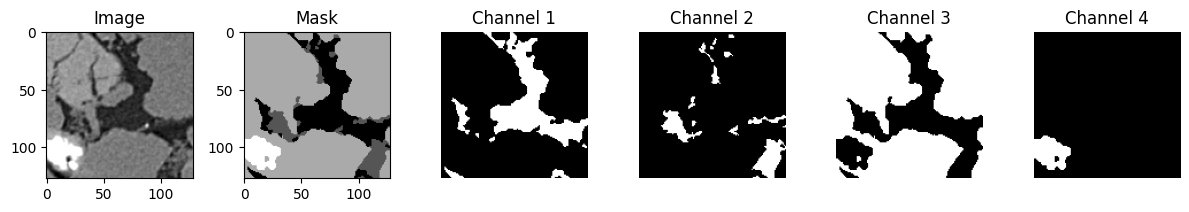

In [11]:
first_mask = final_mask[0]  # Shape (128, 128, 4)

# Set up a figure with 4 subplots
fig, axes = plt.subplots(1, 6, figsize=(12, 6))

axes[0].imshow(images[0], cmap = "gray") # Pass the image data directly
axes[0].set_title("Image") # Set the title separately

axes[1].imshow(masks[0], cmap = "gray") # Pass the image data directly
axes[1].set_title("Mask") # Set the title separately

for i in range(4):
    axes[i + 2].imshow(first_mask[:, :, i], cmap='gray')  # Adjusted index for axes
    axes[i + 2].set_title(f'Channel {i + 1}')
    axes[i + 2].axis('off')

plt.tight_layout()
plt.show()

In [12]:
def UNet(input_shape=(128, 128, 1)):

  inputs = Input(input_shape)
  c1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
  c1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(c1)
  p1 = MaxPool2D(2)(c1)

  c2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(p1)
  c2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(c2)
  p2 = MaxPool2D(2)(c2)

  c3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(p2)
  c3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(c3)
  p3 = MaxPool2D(2)(c3)

  c4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(p3)
  c4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(c4)
  p4 = MaxPool2D(2)(c4)

  b1 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(p4)
  b1 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(b1)

  d1 = UpSampling2D(2)(b1)
  d1 = Conv2D(512, 3, activation = 'relu', padding = 'same')(d1)
  d1 = concatenate([d1, c4])
  d1 = Conv2D(512, 3, activation = 'relu', padding = 'same')(d1)
  d1 = Conv2D(512, 3, activation = 'relu', padding = 'same')(d1)

  d2 = UpSampling2D(2)(d1)
  d2 = Conv2D(256, 3, activation = 'relu', padding = 'same')(d2)
  d2 = concatenate([d2, c3])
  d2 = Conv2D(256, 3, activation = 'relu', padding = 'same')(d2)
  d2 = Conv2D(256, 3, activation = 'relu', padding = 'same')(d2)

  d3 = UpSampling2D(2)(d2)
  d3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(d3)
  d3 = concatenate([d3, c2])
  d3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(d3)
  d3 = Conv2D(128, 3, activation = 'relu', padding = 'same')(d3)

  d4 = UpSampling2D(2)(d3)
  d4 = Conv2D(64, 3, activation = 'relu', padding = 'same')(d4)
  d4 = concatenate([d4, c1])
  d4 = Conv2D(64, 3, activation = 'relu', padding = 'same')(d4)
  d4 = Conv2D(64, 3, activation = 'relu', padding = 'same')(d4)

  outputs = Conv2D(4, (1, 1), activation = 'softmax')(d4)

  model = tf.keras.Model(inputs, outputs)

  return model


In [13]:
model = UNet()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │  4,719,104 │ up_sampling2d[0]

 Total params: 34,512,388 (131.65 MB)

 Trainable params: 34,512,388 (131.65 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(images, final_mask, test_size = 0.1, random_state = 42)

In [15]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size = 16, epochs = 20, validation_data = (np.array(X_test), np.array(y_test)))

Epoch 1/20


I0000 00:00:1730812072.409359      80 service.cc:145] XLA service 0x7d96d8002740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730812072.409433      80 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/90 ━━━━━━━━━━━━━━━━━━━━ 30:45 21s/step - accuracy: 0.7559 - loss: 0.6884

I0000 00:00:1730812086.679915      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 142ms/step - accuracy: 0.6872 - loss: 12.0950 - val_accuracy: 0.8928 - val_loss: 0.1234
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.8867 - loss: 0.1421 - val_accuracy: 0.9316 - val_loss: 0.0797
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9358 - loss: 0.0826 - val_accuracy: 0.9232 - val_loss: 0.0967
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9403 - loss: 0.0752 - val_accuracy: 0.9044 - val_loss: 0.1122
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9380 - loss: 0.0790 - val_accuracy: 0.9645 - val_loss: 0.0434
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9586 - loss: 0.0520 - val_accuracy: 0.9593 - val_loss: 0.0508
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9615 - loss: 0.0532 - val_accuracy: 0.9687 - val_loss: 0.0395
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.9692 - loss: 0.0409 - val_accuracy: 0.96

In [16]:
pred = model.predict(np.array(X_test))
pred_threshold = (pred > 0.5).astype(np.uint8)

test_masks_full = []
test_masks = []
for y in y_test:
    first_mask = y 
    test_masks.append(first_mask)
    single_mask_test = np.sum(first_mask * np.arange(4), axis=-1)
    single_mask_test = single_mask_test.astype(np.uint8)
    test_masks_full.append(single_mask_test)

pred_masks_full = []
pred_masks = []
for p in pred_threshold:
    first_pred = p
    pred_masks.append(first_pred)
    single_mask_pred = np.sum(first_pred * np.arange(4), axis=-1)
    single_mask_pred = single_mask_pred.astype(np.uint8)
    pred_masks_full.append(single_mask_pred)

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step


In [17]:
def plot_results(X_test_sample, single_mask_test, single_mask_pred, first_mask, first_pred, j):

    fig, axes = plt.subplots(2, 6, figsize=(12, 6))

    axes[0][0].imshow(X_test_sample, cmap = "gray") # Pass the image data directly
    axes[0][0].set_title(f"Image {j}") # Set the title separately

    axes[0][1].imshow(single_mask_test) # Pass the image data directly
    axes[0][1].set_title(f"Actual Mask {j}") # Set the title separately

    for i in range(4):
        axes[0][i + 2].imshow(first_mask[:, :, i])  # Adjusted index for axes
        axes[0][i + 2].set_title(f'Actual Channel {i + 1}')
        axes[0][i + 2].axis('off')

    axes[1][0].imshow(X_test_sample, cmap = "gray") # Pass the image data directly
    axes[1][0].set_title(f"Image {j}") # Set the title separately    

    axes[1][1].imshow(single_mask_pred) # Pass the image data directly
    axes[1][1].set_title(f"Predicted Mask {j}") # Set the title separately

    for i in range(4):
        axes[1][i + 2].imshow(first_pred[:, :, i])  # Adjusted index for axes
        axes[1][i + 2].set_title(f'Predicted Channel {i + 1}')
        axes[1][i + 2].axis('off')
    plt.tight_layout()
    plt.show()

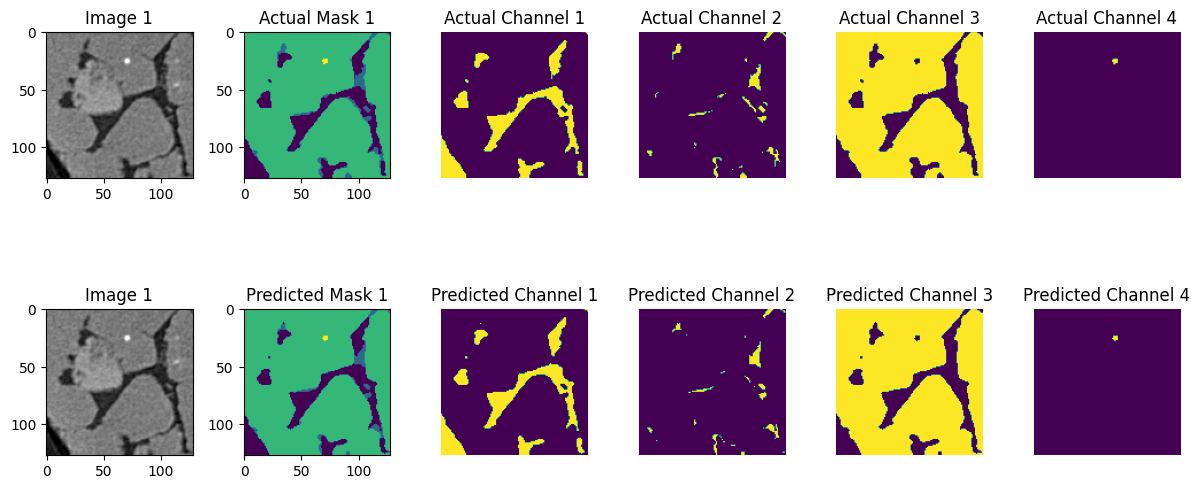

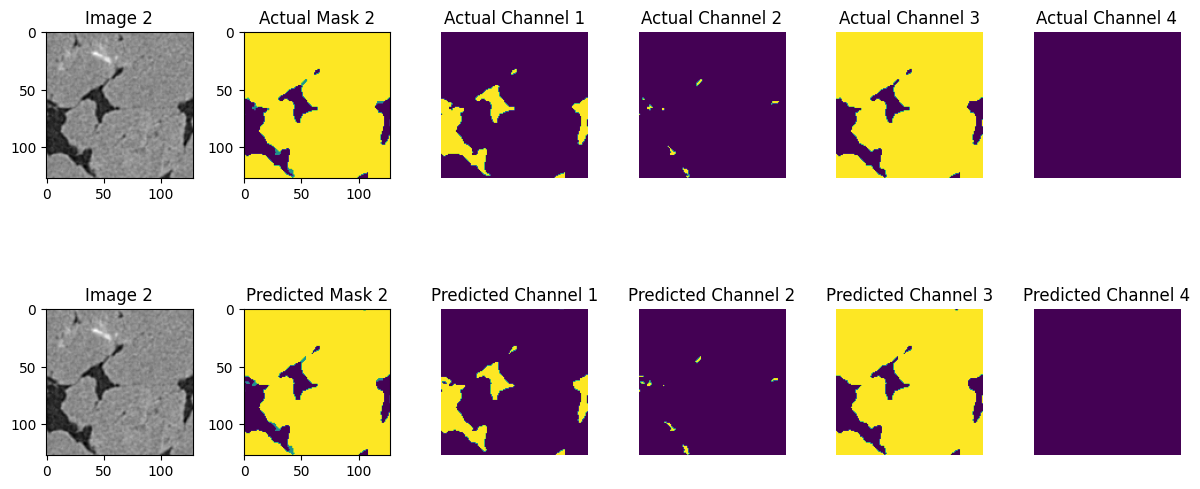

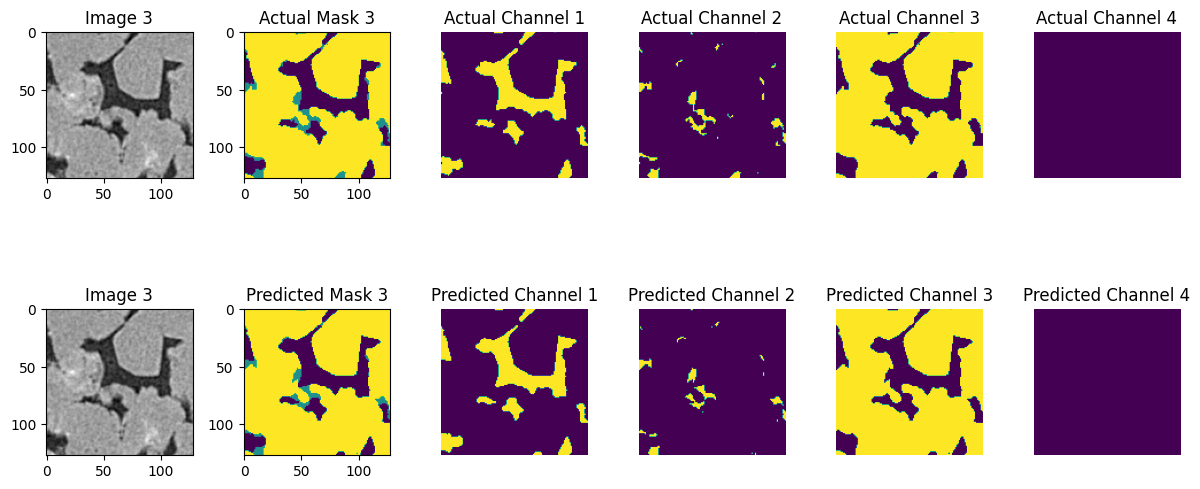

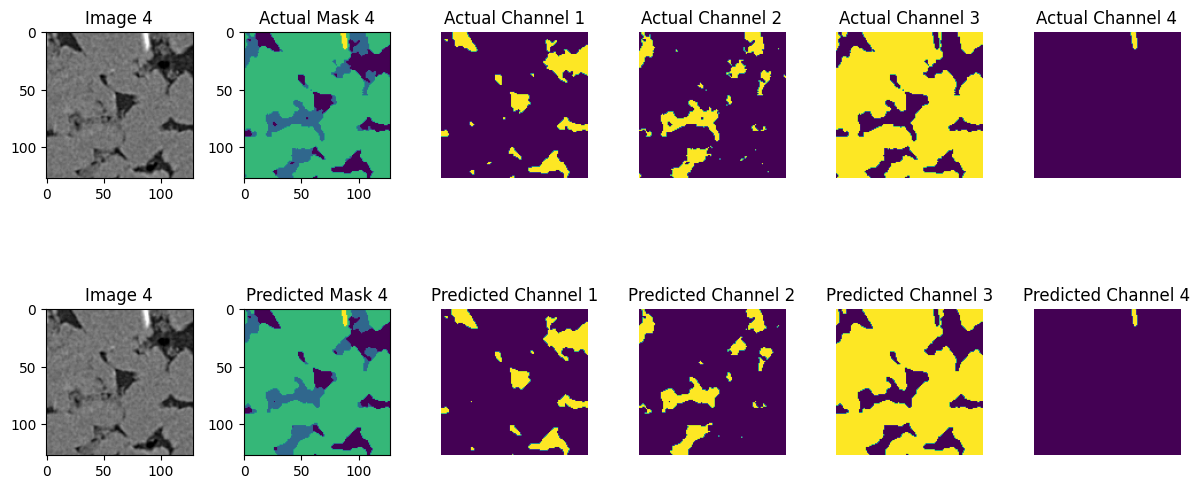

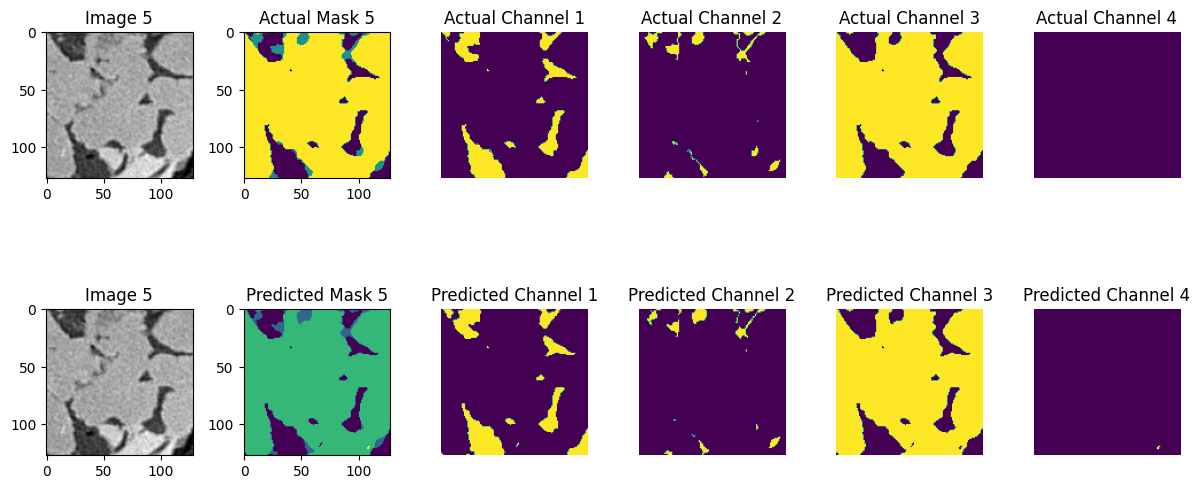

In [18]:
num_examples = 5
for i in range(num_examples):
    plot_results(X_test[i], test_masks_full[i], pred_masks_full[i], test_masks[i], pred_masks[i], i+1)

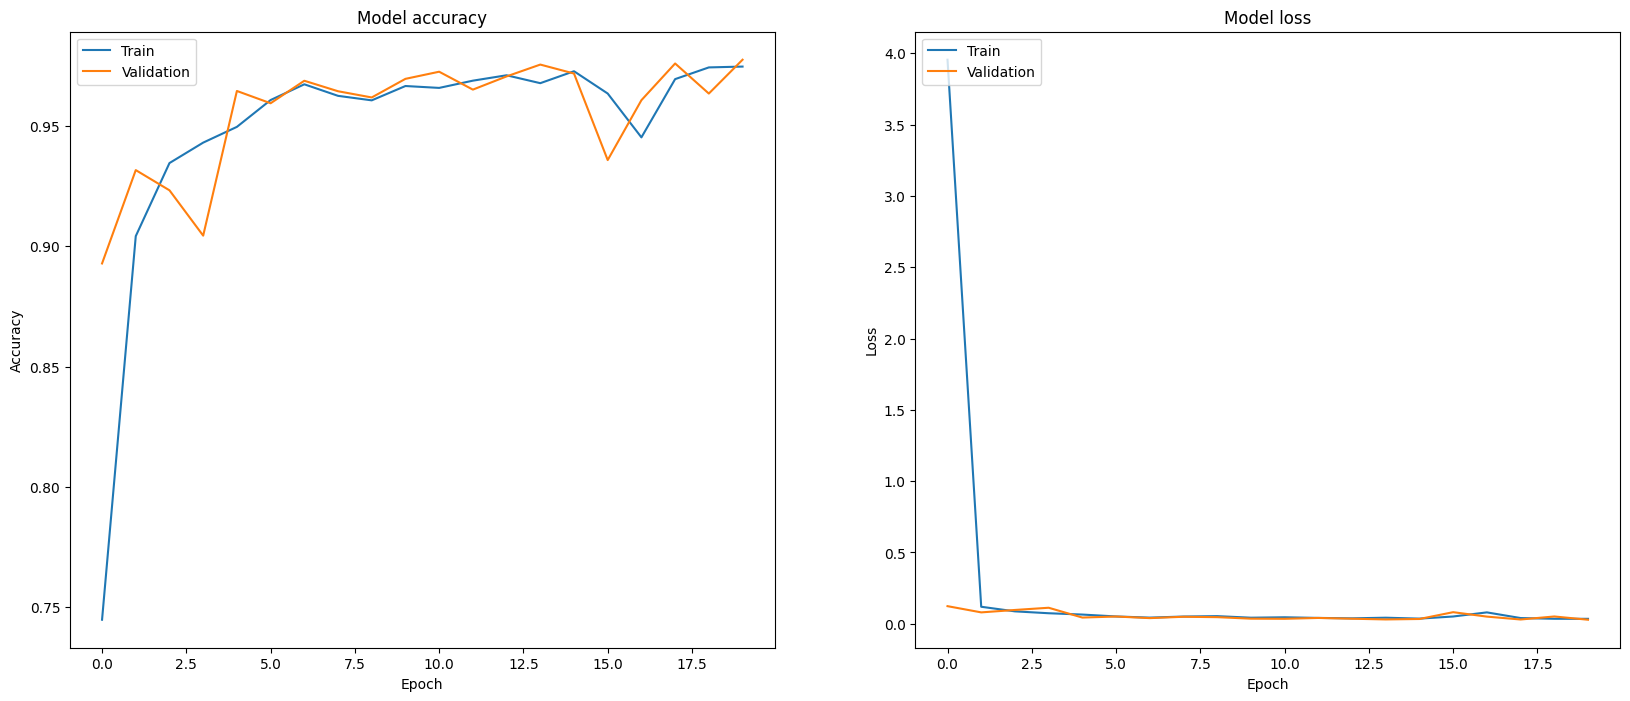

In [19]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()